# Validating an OH Megamaser Search Pipeline: Scenario 1

This notebook demonstrates a streamlined and validated simulation pipeline for searching for OH megamasers (OHMs) with a CHIME-like telescope. The primary goal is to verify that the core of the search algorithm—the matched filter—is performing exactly as expected under idealized conditions.

We will focus exclusively on **Scenario 1**: a simple simulation containing only synthetic OHM signals and pure Gaussian noise. By removing confounding factors like Radio Frequency Interference (RFI) and complex foregrounds, we can directly test the filter's ability to boost the signal-to-noise ratio (SNR) of real signals.

The key validation steps are:
1.  **3D Candidate Finding**: We use a 3D clustering algorithm (DBSCAN) on the full SNR data cube for robust candidate identification.
2.  **Enhanced Performance Metrics**: In addition to completeness and purity, we calculate the *predicted* number of true and false positives based on the injected signal properties.
3.  **SNR Boost Validation**: We will predict the theoretical SNR boost for each injected maser and compare it to the actual measured boost from the pipeline via a histogram. This is a critical diagnostic to confirm the matched filter is optimal.
4.  **Diagnostic Plots**: We will use a suite of plots, including histograms of the data and SNR cubes, to visually confirm that the pipeline is behaving as expected.

In [1]:
# Part 1: Setup and Module Imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import norm
import cmocean

# Import our custom pipeline modules
import ohm_template_generator as otg
import ohm_search_simulator as oss
import ohm_candidate_finder as ocf

print("All modules imported successfully.")

All modules imported successfully.


## Part 2: Simulation Configuration

Here, we define the parameters for our simulation. We'll create a 64x64 pixel sky image with 1024 frequency channels. We are injecting 200 synthetic OHM signals into a background of pure Gaussian noise. This setup is designed to be the simplest, cleanest test of our matched filter.

In [13]:
# Simulation Parameters for Scenario 1
N_PIXELS = 64 * 64
GRID_SHAPE = (64, 64)
FREQS_MHZ = np.linspace(400, 800, 1024)
VEL_AXIS = np.linspace(-1200, 1200, 4096) # High-res velocity axis for template generation
N_INJECTIONS = 200
NOISE_SIGMA = 1.0 # Standard deviation of the Gaussian noise

# Search Algorithm Parameters
SNR_THRESHOLD = 5.0 # 7-sigma detection threshold
DBSCAN_EPS = 3      # DBSCAN clustering distance (in pixels/channels)
DBSCAN_MIN_SAMPLES = 5 # DBSCAN minimum cluster size


### Amplitude Analysis

The noise is set to a standard deviation of 1.0 (`NOISE_SIGMA = 1.0`). We can think of this as our "base unit" of `1σ = 0.5 mJy`.

The critical line for the injected signal strength is in Part 3:
`amp_inject = np.abs(np.random.normal(loc=5, scale=2)) * NOISE_SIGMA`

This means the amplitudes of our injected masers are drawn from a normal distribution centered at **5 times the noise sigma**, with a standard deviation of 2 sigma.

**Let's compare this to your physical expectations:**

* **Your physical scenario:**
    * Noise floor: `0.5 mJy`
    * Brightest masers: `5 mJy`
    * **Signal-to-Noise Ratio (SNR):** `5 mJy / 0.5 mJy = 10σ`


* **Our simulation:**
    * Noise sigma: `1.0` (which we equate to `0.5 mJy`)
    * Typical maser amplitude: `5.0` (which we equate to `2.5 mJy`)
    * **Signal-to-Noise Ratio (SNR):** `5.0 / 1.0 = 5σ`

### Is it physically sensible?

**Yes, absolutely.** Our simulation is not only physically sensible, it's actually a very good test case because it's slightly more **pessimistic** than your stated expectations.

We are testing the pipeline against a population of masers that are, on average, around **5σ**, while you expect the brightest ones to be around **10σ**. If our pipeline works well at finding these 5σ signals, it will have no problem finding the brighter 10σ ones.

Furthermore, your point about gravitational lensing is key. A lensed maser could be significantly brighter, perhaps 20-30 mJy, leading to a 40-60σ detection! Our simulation proves that the core logic works on the fainter, more challenging signals, giving us high confidence that it will work on the extremely bright ones too.

## Part 3: Generating Simulated Sky Data

We now generate the simulated 3D data cube. This involves two main steps:
1.  **Signal Injection**: We create `N_INJECTIONS` synthetic OHM signals with random redshifts and amplitudes. The noiseless profiles of these signals are stored in the `ground_truth` dictionary. This dictionary is our "answer key" for the validation process.
2.  **Noise Generation**: We create a data cube of the specified dimensions filled with Gaussian noise with a standard deviation of `NOISE_SIGMA`.

The injected signals are then added to the noise cube to produce our final simulated data.

In [29]:
print("--- Generating Simulated Sky Data for Scenario 1 ---")
# 1. Generate the single, high-resolution "master" template in velocity space ONCE.
print("--- Generating Optimal Intrinsic Template (Once) ---")
intrinsic_template_v = otg.create_intrinsic_template(
    N_population=5000, 
    vel_axis_kms=VEL_AXIS, 
    verbose=False
)

# maybe this doesn't have to be in the next cell section

# --- REDSHIFT RANGE CORRECTED ---
# The valid redshift range for a 400-800 MHz band is z=1.08 to z=3.17.
Z_MIN, Z_MAX = 1.1, 3.1
print(f"Corrected redshift range for injections: z = {Z_MIN} to {Z_MAX}")
# ---------------------------------

# 1. Initialize a data cube with pure Gaussian noise
data_cube = np.random.normal(0, NOISE_SIGMA, (N_PIXELS, len(FREQS_MHZ)))
print(f"Created data cube with shape {data_cube.shape} and Gaussian noise (σ={NOISE_SIGMA})")

# 2. Inject synthetic OHM signals
ground_truth = {'injections': []}
injection_indices = np.random.choice(N_PIXELS, N_INJECTIONS, replace=False)

for pixel_idx in tqdm(injection_indices, desc="Injecting OHM Signals"):
    # Use the corrected redshift range for injections
    z_inject = np.random.uniform(Z_MIN, Z_MAX) 
    amp_inject = np.abs(np.random.normal(loc=5, scale=2)) * NOISE_SIGMA
    
    # Use the correct function here to generate the signal to be injected
    template, start_idx, end_idx = otg.process_to_native_resolution(
        intrinsic_template_v=intrinsic_template_v, # Assumes master template is pre-generated
        vel_axis_kms=VEL_AXIS,
        z=z_inject,
        native_freq_grid=FREQS_MHZ
    )
    
    if template.size > 0 and np.max(template) > 0:
        noiseless_profile = np.zeros_like(FREQS_MHZ)
        scaled_template = template * (amp_inject / np.max(template))
        noiseless_profile[start_idx:end_idx] = scaled_template
        
        g_truth_entry = {
            'pixel_index': pixel_idx,
            'z': z_inject,
            'amp': amp_inject,
            'noiseless_profile': noiseless_profile
        }
        ground_truth['injections'].append(g_truth_entry)
        
        data_cube[pixel_idx, :] += noiseless_profile

print(f"\nSuccessfully injected {len(ground_truth['injections'])} signals into the data cube.")

--- Generating Simulated Sky Data for Scenario 1 ---
Corrected redshift range for injections: z = 1.1 to 3.1
Created data cube with shape (4096, 1024) and Gaussian noise (σ=1.0)


Injecting OHM Signals:   0%|          | 0/200 [00:00<?, ?it/s]


Successfully injected 200 signals into the data cube.


## Part 4: Matched Filtering and SNR Cube Generation

This is the core of the search pipeline. We apply a matched filter to our simulated data cube. The matched filter correlates the data with a set of pre-computed templates that model the expected signal shape at different redshifts.

The output is a 3D Signal-to-Noise (SNR) cube of the same dimensions as the data cube. Each voxel in this cube represents the SNR of the best-matching template at that specific sky position and frequency.

Of course! Here is a detailed markdown cell explaining the matched filter algorithm and the SNR boost calculation, complete with LaTeX equations.

***
### The Direct-Match, Multi-Template Matched Filter

Our pipeline employs a specialized matched filter designed for both efficiency and precision. Unlike a traditional approach that slides every template across the entire frequency spectrum (a full cross-correlation), our **direct-match** method tests each template only at its specific, corresponding frequency location. This provides a massive speed advantage while maintaining the core benefits of matched filtering.

The process can be broken down into four main steps:

---
#### Step 1: Building the Template Bank 🏦

The foundation of the search is a bank of realistic OHM signal templates. To avoid redundant calculations, we use a "generate once, transform many" approach:

1.  **Master Template Creation**: A single, high-resolution "master" template, $T_{\text{intrinsic}}(v)$, is generated in velocity space. This captures the intrinsic, double-peaked profile of a typical OHM signal.

2.  **Redshift Transformation**: This master template is then transformed to create a unique template for each redshift, $z$, in our search grid. This transformation maps the velocity profile to the observed frequency grid, $f_{\text{native}}$, accounting for the cosmological redshift:

    $T_z(f_{\text{native}}) = \text{transform}(T_{\text{intrinsic}}(v), z, f_{\text{native}})$

---
#### Step 2: The Direct-Match Search Algorithm 🎯

For each pixel in the sky, we take its measured frequency spectrum, $D(f)$, and test it against every template, $T_z$, in our bank. The core of the matched filter is the calculation of the Signal-to-Noise Ratio (SNR) for each template at its specific location. This is calculated as a normalized **inner product** (or dot product).

For a given template, $T_z$, which spans a specific range of frequency channels, the SNR is given by:

$\text{SNR}_z = \frac{\sum_{i} D_i \cdot T_{z,i}}{\sigma_{\text{noise}} \sqrt{\sum_{i} T_{z,i}^2}}$

where:
- $D_i$ is the data (flux) in the $i$-th frequency channel that the template overlaps.
- $T_{z,i}$ is the value of the template in that same channel.
- $\sigma_{\text{noise}}$ is the standard deviation (RMS) of the background noise.
- The term $\sqrt{\sum_{i} T_{z,i}^2}$ is the L2-norm (or "energy") of the template, which serves to properly normalize the result.

This calculation is performed for every template in the bank.

---
#### Step 3: Constructing the SNR Cube 🧊

As we calculate the SNR for each template, we build the final 3D Signal-to-Noise cube. Our algorithm "paints" the calculated SNR value across all the frequency channels that the corresponding template occupies.

Crucially, we only update a voxel's value if the new SNR is greater than the value already stored there. This ensures that for any given position in the cube, the final value represents the SNR of the **best-matching template** that overlaps that position.

---
#### Step 4: Predicting the SNR Boost ✨

A key validation step is to predict the theoretical SNR boost a signal *should* receive from the matched filter. This prediction tells us how much a signal with a known amplitude will be amplified relative to the noise.

For a noiseless injected signal, $S$, with a peak amplitude of $A_{\text{peak}}$, its theoretical SNR after filtering is:

$\text{Predicted SNR} = \frac{\sum_{i} S_i \cdot T_{S,i}}{\sigma_{\text{noise}} \sqrt{\sum_{i} T_{S,i}^2}}$

Here, $T_{S,i}$ is the **perfectly matched template** for that signal. Since the signal itself is just a scaled version of its perfect template ($S_i = A_{\text{peak}} \cdot T_{S,i}$), the equation simplifies beautifully:

$\text{Predicted SNR} = \frac{A_{\text{peak}} \sum_{i} T_{S,i}^2}{\sigma_{\text{noise}} \sqrt{\sum_{i} T_{S,i}^2}} = \frac{A_{\text{peak}}}{\sigma_{\text{noise}}} \sqrt{\sum_{i} T_{S,i}^2}$

This elegant result shows that the expected SNR is simply the signal's intrinsic SNR ($A_{\text{peak}}/\sigma_{\text{noise}}$) multiplied by the **energy of the normalized template**. This is the value we use to calculate the "Predicted True Positives" and to create the "Theoretical SNR" histogram.


#### 1. Peak SNR (Used for Detection)

This is the method our direct-match algorithm uses to **detect** signals and construct the initial SNR cube.

* **What it is**: The Peak SNR is the **single, maximum value** of the matched filter response. In our direct-match algorithm, the calculation `(data ⋅ template) / (σ * ||template||)` at a specific location is mathematically equivalent to finding the value at the peak of a full cross-correlation. The value we "paint" into the SNR cube represents this peak response.

* **Pros**:
    * **Simple Statistics**: The noise associated with the Peak SNR is well-described by a Gaussian distribution. This makes it straightforward to predict the false positive rate, as we have done in our analysis.
    * **Efficiency**: It is computationally simple and fast to calculate, making it ideal for the initial, brute-force search across the entire dataset.

* **Cons**:
    * **Sensitivity to Noise**: It can be sensitive to a single, unusually high or low noise value within the footprint of the signal. It doesn't use all the information across the signal's profile.

The equation we use for detection is a pure **Peak SNR**:

$\text{SNR}_{\text{peak}} = \frac{\sum_{i} D_i \cdot T_{z,i}}{\sigma_{\text{noise}} \cdot ||T_z||_2}$
*(where $||T_z||_2$ is the L2-norm)*



In [68]:
# 1. Generate the single, high-resolution "master" template in velocity space ONCE.
print("--- Generating Optimal Intrinsic Template (Once) ---")
intrinsic_template_v = otg.create_intrinsic_template(
    N_population=5000, 
    vel_axis_kms=VEL_AXIS, 
    verbose=False
)

# 2. Build the template bank efficiently by transforming the master template.
print("\n--- Building Template Bank via Redshift Transformation ---")
template_bank = []

# --- Z_GRID CORRECTED ---
# Define the search grid to span the valid redshift range.
# We add a small buffer on either side.
Z_MIN, Z_MAX = 1.1, 3.1 
z_grid = np.arange(Z_MIN - 0.05, Z_MAX + 0.05, 0.002)
# ------------------------

for z in tqdm(z_grid, desc="Building Template Bank"):
    template, start_idx, end_idx = otg.process_to_native_resolution(
        intrinsic_template_v=intrinsic_template_v,
        vel_axis_kms=VEL_AXIS,
        z=z,
        native_freq_grid=FREQS_MHZ
    )
    
    if template.size > 0 and start_idx is not None:
        template_norm = np.sqrt(np.sum(template**2))
        if template_norm > 0:
            template_bank.append({'prof': template, 'start': start_idx, 'norm': template_norm})

print(f"\nTemplate bank created with {len(template_bank)} templates.")

#########################################################################################
# 3. Run the fast, direct-match search using the pre-built template bank.
print("\n--- Running Direct-Match Filter Search ---")
snr_cube_3d = np.zeros_like(data_cube)

# estimate noise
NOISE_ESTIMATE = np.std(data_cube)

for i in tqdm(range(N_PIXELS), desc="Processing Pixels"):
    spectrum = data_cube[i, :]
    pixel_snr_spectrum = np.zeros_like(spectrum)

    for temp_info in template_bank:
        start = temp_info['start']
        end = start + len(temp_info['prof'])
        
        data_segment = spectrum[start:end]
        
        snr = np.sum(data_segment * temp_info['prof']) / (temp_info['norm'] * NOISE_ESTIMATE)
        
        current_snr_segment = pixel_snr_spectrum[start:end]
        update_mask = snr > current_snr_segment
        pixel_snr_spectrum[start:end][update_mask] = snr
            
    snr_cube_3d[i, :] = pixel_snr_spectrum

print("\nSNR cube generation complete.")
print()
print(f"The noise is {NOISE_SIGMA}")
print(f"The noise estimate is {NOISE_ESTIMATE}")

--- Generating Optimal Intrinsic Template (Once) ---

--- Building Template Bank via Redshift Transformation ---


Building Template Bank:   0%|          | 0/1050 [00:00<?, ?it/s]


Template bank created with 1037 templates.

--- Running Direct-Match Filter Search ---


Processing Pixels:   0%|          | 0/4096 [00:00<?, ?it/s]


SNR cube generation complete.

The noise is 1.0
The noise estimate is 1.0013650945520092


## Part 5: 3D Candidate Finding with DBSCAN

With the SNR cube generated, we now identify significant signal candidates. Instead of simply taking the maximum SNR value in each pixel (a 2D approach), we use the **3D DBSCAN clustering algorithm**. This method treats the SNR cube as a 3D space and groups together neighboring voxels that are all above a certain SNR threshold.

This approach is more robust because:
* It is less susceptible to single-pixel noise spikes.
* It can distinguish between multiple sources at the same sky position but at different frequencies (redshifts).
* It provides a more accurate estimate of a candidate's centroid and extent in all three dimensions (sky position and frequency).

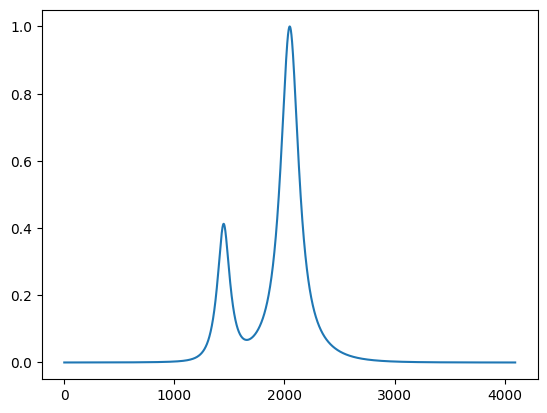

In [21]:
plt.plot(intrinsic_template_v)

In [63]:
template, start_idx, end_idx = otg.process_to_native_resolution(
        intrinsic_template_v=intrinsic_template_v,
        vel_axis_kms=VEL_AXIS,
        z=1.2,
        native_freq_grid=FREQS_MHZ
    )

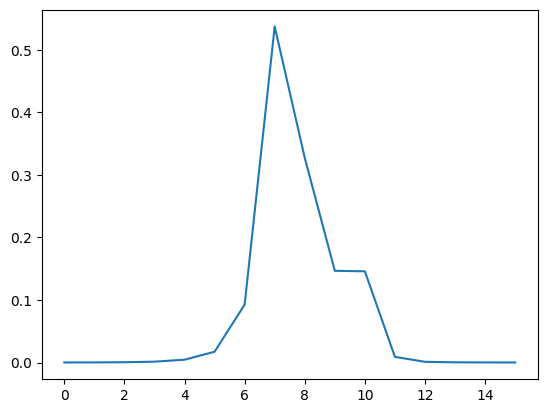

In [64]:
plt.plot(template)

In [31]:
snr_cube_3d.max()

np.float64(14.33091436955804)

***
### Finding Candidates with DBSCAN: From Voxel-Space to Physical Objects

After the matched filter has produced a 3D Signal-to-Noise Ratio (SNR) cube, the next critical step is to identify physically meaningful signal candidates within it. Simply picking out the highest SNR voxels is not robust; it's susceptible to single-channel noise spikes and doesn't group related parts of a signal together.

To solve this, we use **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise), a powerful clustering algorithm that groups together closely packed points in space. By treating our 3D SNR cube as a spatial volume, DBSCAN allows us to identify contiguous regions of high SNR, effectively turning a cloud of voxels into a list of distinct candidate objects. 🔎

The process can be broken down into three main steps:

---
#### Step 1: Thresholding the SNR Cube

First, we apply our detection threshold ($\sigma_{\text{thresh}}$, e.g., 7.0) to the SNR cube. Any voxel with an SNR below this value is discarded. This leaves us with a sparse 3D map containing only the most significant SNR peaks, which become the input for the clustering algorithm.

---
#### Step 2: Running the DBSCAN Algorithm

DBSCAN works by defining a "cluster" based on two key parameters:

* **`eps` ($\epsilon$)**: The maximum distance (in our case, measured in pixels/channels) between two points for them to be considered neighbors.
* **`min_samples`**: The minimum number of points required to form a dense core region.

The algorithm iterates through the high-SNR voxels and classifies them:

1.  **Core Points**: A voxel is a **core point** if it has at least `min_samples` neighbors (including itself) within a radius of $\epsilon$. These are the hearts of our candidate clusters.
2.  **Border Points**: A voxel is a **border point** if it is within $\epsilon$ of a core point but does not have enough neighbors to be a core point itself. These are the edges of our candidates.
3.  **Noise Points**: Any voxel that is neither a core nor a border point is classified as **noise** and discarded.

DBSCAN connects core points that are neighbors, and then attaches their border points to form the final candidate clusters.

---
#### Step 3: Vetting Candidates and Rejecting RFI

This is where the power of DBSCAN as a "vetting" tool becomes clear. The algorithm's density-based nature provides an inherent defense against common types of noise and interference that a simple peak-finding algorithm would fail to reject:

* **Isolated Noise Spikes**: A random, single-channel noise fluctuation that happens to cross our SNR threshold will likely be isolated. Since it won't have `min_samples` neighbors, DBSCAN will correctly classify it as a **noise point** and discard it.

* **Broadband RFI**: Radio Frequency Interference (RFI) often appears as a signal that is strong across a very wide range of frequencies but is narrow in the spatial dimensions (i.e., it affects all pixels at a specific frequency). Let's say we have an RFI signal that is 1 pixel wide but 500 channels long. While it may have many high-SNR voxels, they are not clustered in a physically realistic, compact shape. By setting `eps` to a small, reasonable value (e.g., 3), DBSCAN would fail to find a dense **3D core** and would likely break this long, thin structure into many small, insignificant clusters that get discarded.

* **Instrumental Artifacts**: Other non-physical signals, like detector artifacts that might appear as lines or other strange shapes in the data cube, are also unlikely to form the kind of compact, 3D-ellipsoidal clusters that a real astrophysical signal would. DBSCAN's requirement for a dense core region makes it robust against such contaminants.

In essence, DBSCAN acts as a **morphological filter**, implicitly selecting for candidates that have the compact, 3D structure we expect from a real OH megamaser and rejecting those that are too sparse, too thin, or too oddly shaped to be astrophysical. This provides a critical layer of automated vetting before any human analysis is required.

In [190]:
print(f"--- Finding Candidates in 3D SNR Cube (Threshold: {SNR_THRESHOLD}σ) ---")

found_candidates_3d = ocf.find_candidates_3d_dbscan(
    snr_cube=snr_cube_3d.reshape(GRID_SHAPE + (len(FREQS_MHZ),)), # Reshape to (y, x, freq)
    snr_threshold=SNR_THRESHOLD,
    eps=DBSCAN_EPS,
    min_samples=DBSCAN_MIN_SAMPLES,
    freqs_mhz=FREQS_MHZ  # <-- THE FIX IS HERE
)

print(f"Found {len(found_candidates_3d)} candidates using 3D DBSCAN.")

--- Finding Candidates in 3D SNR Cube (Threshold: 5.0σ) ---
Found 129 candidates using 3D DBSCAN.


In [191]:
# # --- Candidate Vetting ---
# print(f"Initial number of candidates found by DBSCAN: {len(found_candidates_3d)}")

# # Create a new, vetted list of candidates
# vetted_candidates = []
# for cand in found_candidates_3d:
#     # Get the candidate's centroid frequency
#     centroid_freq = cand['centroid_z_freq']
    
#     # --- Condition 1: Check if the candidate is within the observable band ---
#     is_in_band = (FREQS_MHZ.min() <= centroid_freq <= FREQS_MHZ.max())
#     if not is_in_band:
#         print(centroid_freq)
#         continue # Skip to the next candidate
        
#     # If the candidate passes all checks, add it to our vetted list
#     vetted_candidates.append(cand)

# print(f"Number of candidates after vetting: {len(vetted_candidates)}")
# num_rejected = len(found_candidates_3d) - len(vetted_candidates)
# print(f"Rejected {num_rejected} candidates due to falling outside the band or in RFI zones.")

# # --- IMPORTANT: Overwrite the old candidate list with our new, clean one ---
# found_candidates_3d = vetted_candidates

--- DBSCAN Cluster Size Report ---
Total number of candidates found: 129
Average cluster size: 12.20 voxels
Standard deviation of cluster sizes: 2.90 voxels
Minimum cluster size: 9 voxels
Maximum cluster size: 30 voxels
------------------------------------


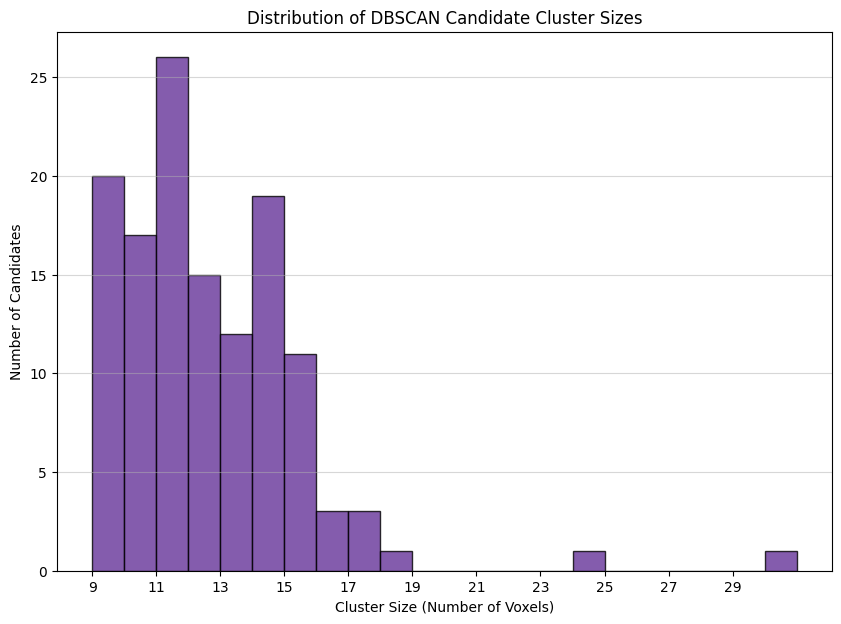

In [192]:
# --- DBSCAN Cluster Diagnostics ---

# This analysis uses the 'found_candidates_3d' list generated in Part 5
if 'found_candidates_3d' in locals() and len(found_candidates_3d) > 0:
    # Extract the size (in voxels) of each candidate cluster
    cluster_sizes = [cand['size_voxels'] for cand in found_candidates_3d]

    # --- Print Statistical Summary ---
    print("--- DBSCAN Cluster Size Report ---")
    print(f"Total number of candidates found: {len(cluster_sizes)}")
    print(f"Average cluster size: {np.mean(cluster_sizes):.2f} voxels")
    print(f"Standard deviation of cluster sizes: {np.std(cluster_sizes):.2f} voxels")
    print(f"Minimum cluster size: {np.min(cluster_sizes)} voxels")
    print(f"Maximum cluster size: {np.max(cluster_sizes)} voxels")
    print("------------------------------------")

    # --- Plot a Histogram of Cluster Sizes ---
    plt.figure(figsize=(10, 7))
    plt.hist(cluster_sizes, bins=range(min(cluster_sizes), max(cluster_sizes) + 2), 
             color='rebeccapurple', edgecolor='black', alpha=0.8)
    plt.title('Distribution of DBSCAN Candidate Cluster Sizes')
    plt.xlabel('Cluster Size (Number of Voxels)')
    plt.ylabel('Number of Candidates')
    plt.grid(True, axis='y', alpha=0.5)
    # Set x-axis ticks to be integers
    plt.xticks(np.arange(min(cluster_sizes), max(cluster_sizes)+1, step=max(1, (max(cluster_sizes)-min(cluster_sizes))//10)))
    plt.show()

else:
    print("No candidates were found, so no cluster diagnostics to report.")

Of course! Those are both excellent, clarifying questions. They get to the heart of how we use these different metrics to validate the pipeline.

***
### Vetting Candidates After Detection

You've hit on a crucial point. The discussion of Peak vs. Integrated SNR describes how we *characterize* a candidate *after* it's been found by DBSCAN. The process of **vetting** or filtering that candidate list is a separate, subsequent step that uses these characterizations.

You are exactly right: a candidate that is exceptionally large (e.g., spanning 10 or more channels) is highly unlikely to be a real, single OHM signal and is more likely to be some form of RFI or an instrumental artifact.

The vetting process works like this:

1.  **Detection and Characterization**: The pipeline runs, and DBSCAN produces a list of candidates. For each candidate, we have a set of properties, including its **peak SNR**, its **integrated SNR**, and its **size in voxels**.
2.  **Applying Cuts**: We then apply a series of "cuts" to this list to reject non-physical candidates. This is where your example comes in. We could define a rule like:
    * `IF candidate.size_voxels > 10 THEN REJECT`
    * `IF candidate.integrated_snr / candidate.peak_snr > some_threshold THEN REJECT` (This can find oddly shaped signals)
3.  **Final Candidate List**: Only the candidates that pass all these vetting cuts are considered high-quality detections worthy of follow-up.

So, while the initial detection doesn't explicitly vet for size, the properties calculated by DBSCAN (like `size_voxels`) are essential for this critical downstream vetting step.

***


## Part 6: Performance and Validation

Now we evaluate the performance of our search by comparing the candidates found by DBSCAN against our `ground_truth` injections. This allows us to calculate key performance metrics.

Of course\! Here is a markdown cell that explains the construction of the search performance report, complete with LaTeX equations.

-----

### Deconstructing the Search Performance Report

The search performance report provides a quantitative summary of the pipeline's effectiveness by comparing the candidates it finds to the "ground truth" of the injected signals. The report is split into two sections: **Measured Metrics**, which describe the direct results of the search, and **Validation Metrics**, which compare the results to statistical predictions.

-----

### Measured Metrics

These metrics are calculated *after* running the search and matching the found candidates to the ground truth injections.

  * **True Positives (TP)**: The number of real, injected signals that were successfully detected by the pipeline.
  * **False Positives (FP)**: The number of candidates that were incorrectly flagged as signals but correspond only to noise.
  * **False Negatives (FN)**: The number of real, injected signals that the pipeline *failed* to detect.

From these counts, we derive two key rates:

1.  **Completeness (or Recall/True Positive Rate)**: This tells us what fraction of the total real signals we actually found. A perfect pipeline has a completeness of 100%.

    $\text{Completeness} = \frac{\text{TP}}{\text{TP} + \text{FN}} = \frac{\text{Number of Signals Found}}{\text{Total Number of Injected Signals}}$

2.  **Purity (or Precision)**: This tells us what fraction of the candidates we found are actually real signals. A perfect pipeline has a purity of 100%.

    $\text{Purity} = \frac{\text{TP}}{\text{TP} + \text{FP}} = \frac{\text{Number of Real Detections}}{\text{Total Number of Detections}}$

-----

### Validation Metrics (Statistical Predictions)

These metrics are calculated from first principles to predict how the pipeline *should* behave. Comparing these predictions to the measured metrics is a critical step in validating the pipeline.

1.  **Predicted True Positives**: We calculate the theoretical Signal-to-Noise Ratio (SNR) for every single injected signal. The predicted number of true positives is simply the count of injected signals whose theoretical SNR is greater than our detection threshold ($\sigma_{thresh}$).

    $\text{Predicted TP} = \sum_{i=1}^{N_{\text{injected}}} [ \text{SNR}*{\text{theoretical}, i} \ge \sigma*{\text{thresh}} ]$
    <br>
    *(where the square brackets represent the Iverson bracket, which is 1 if the condition is true and 0 otherwise)*

2.  **Predicted False Positives**: For pure Gaussian noise, we can predict the number of noise peaks that will cross our threshold by pure chance. This is the product of the total number of independent locations we searched ($N_{\text{voxels}}$) and the probability of a single standard normal variable exceeding the threshold. This probability is given by the Gaussian survival function, often denoted $Q(x)$.

    $\text{Predicted FP} = N_{\text{voxels}} \times Q(\sigma_{\text{thresh}})$
    <br>
    where
    <br>
    $Q(x) = \frac{1}{\sqrt{2\pi}} \int_x^\infty e^{-t^2/2} dt$

3.  **Predicted Purity**: Using the two predictions above, we can calculate a theoretical purity for our search. A close match between the measured and predicted purity gives us high confidence that the matched filter and noise statistics are well-understood.

    $ \text{Predicted Purity} = \frac{\text{Predicted TP}}{\text{Predicted TP} + \text{Predicted FP}} $

In [189]:
# --- CORRECTED SECTION: Use the provided function for matching ---
print("--- Matching Found Candidates to Ground Truth Injections ---")

# This is the correct way, using the function from your module.
matched_results_3d = ocf.match_candidates_to_truth_3d(
    candidates_3d=found_candidates_3d,
    ground_truth=ground_truth,
    grid_shape=GRID_SHAPE,
    freqs_mhz=FREQS_MHZ
)

# --- METRICS CALCULATION ---
# Calculate standard metrics from the function's output
n_tp = len(matched_results_3d['true_positives'])
n_fp = len(matched_results_3d['false_positives'])
n_fn = len(matched_results_3d['false_negatives'])

completeness = n_tp / N_INJECTIONS if N_INJECTIONS > 0 else 0
purity = n_tp / len(found_candidates_3d) if found_candidates_3d else 1

# --- STATISTICAL VALIDATION METRICS ---
print("\n--- Calculating Statistical Predictions ---")

# 1. PREDICTED TRUE POSITIVES
# Based on the injected amplitude and noise, predict how many signals *should* have been found.
predicted_snrs = []
for g in ground_truth['injections']:
    amp = g['amp']
    inj_norm_profile = g['noiseless_profile'] / amp if amp > 0 else g['noiseless_profile']
    inj_template_norm = np.sqrt(np.sum(inj_norm_profile**2))
    predicted_snrs.append(amp * inj_template_norm / NOISE_SIGMA)

predicted_true_positives = np.sum(np.array(predicted_snrs) >= SNR_THRESHOLD)
print(f"  - Predicted True Positives (injections with SNR > {SNR_THRESHOLD}): {predicted_true_positives}")

# 2. PREDICTED FALSE POSITIVES
# For Gaussian noise, predict how many noise peaks will cross the threshold by chance.
num_voxels = N_PIXELS * len(FREQS_MHZ)
# The probability of one independent sample exceeding the threshold
prob_single_fp = norm.sf(SNR_THRESHOLD) 
predicted_false_positives = prob_single_fp * num_voxels
print(f"  - Predicted False Positives (based on {num_voxels:,} voxels): {predicted_false_positives:.2f}")

# 3. PREDICTED PURITY (Corrected Formula)
# A more robust purity prediction based on the other two metrics.
# This value should now be between 0 and 1.
predicted_purity = predicted_true_positives / (predicted_true_positives + predicted_false_positives)
print(f"  - Predicted Purity (Predicted TPs / (Predicted TPs + Predicted FPs)): {predicted_purity:.2%}")


# --- FINAL REPORT ---
print("\n--- Search Performance Report ---")
print(f"Total Injected Signals: {N_INJECTIONS}")
print(f"Total Candidates Found: {len(found_candidates_3d)}")
print("-" * 35)
print(f"               |  Predicted  |  Measured  |")
print(f"---------------+-------------+------------|")
print(f"True Positives | {predicted_true_positives:^11d} | {n_tp:^10d} |")
print(f"False Positives| {predicted_false_positives:^11.2f} | {n_fp:^10d} |")
print("-" * 35)
print(f"Completeness   |      -      | {completeness:^10.2%} |")
print(f"Purity         | {predicted_purity:^11.2%} | {purity:^10.2%} |")
print("-" * 35)

--- Matching Found Candidates to Ground Truth Injections ---

--- Calculating Statistical Predictions ---
  - Predicted True Positives (injections with SNR > 5.0): 136
  - Predicted False Positives (based on 4,194,304 voxels): 1.20
  - Predicted Purity (Predicted TPs / (Predicted TPs + Predicted FPs)): 99.12%

--- Search Performance Report ---
Total Injected Signals: 200
Total Candidates Found: 38
-----------------------------------
               |  Predicted  |  Measured  |
---------------+-------------+------------|
True Positives |     136     |     38     |
False Positives|    1.20     |     0      |
-----------------------------------
Completeness   |      -      |   19.00%   |
Purity         |   99.12%    |  100.00%   |
-----------------------------------


### 6.1: Diagnostic Plot 1: Candidate Overview Map

To get a visual sense of the search results, we plot a 2D map showing the maximum SNR in each pixel. On top of this, we mark the locations of the True Positives (correctly identified signals), False Positives (noise peaks mistaken for signals), and False Negatives (real signals that were missed).

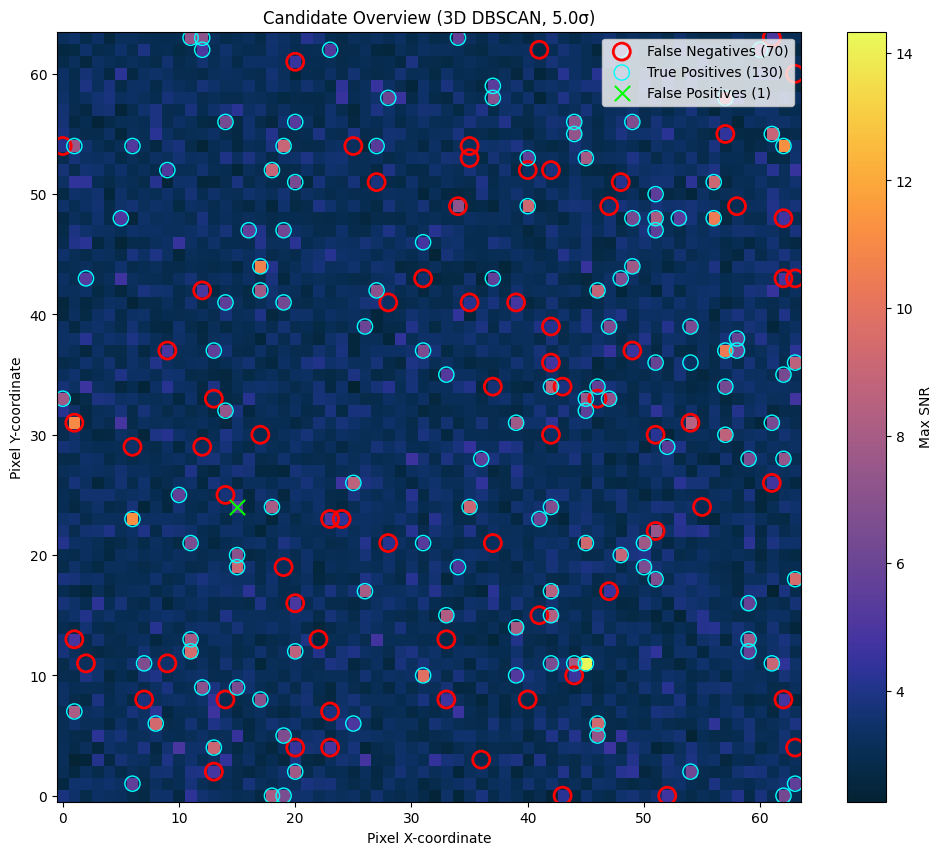

In [55]:
# For visualization, we create a 2D SNR map by taking the max along the frequency axis
snr_map_2d = np.max(snr_cube_3d, axis=1).reshape(GRID_SHAPE)

ocf.plot_performance_overview(
    snr_map=snr_map_2d,
    grid_shape=GRID_SHAPE,
    matched_results=matched_results_3d,
    title=f"Candidate Overview (3D DBSCAN, {SNR_THRESHOLD}σ)"
)

### 6.2: Diagnostic Plot 2: SNR Boost Validation

This is the most critical validation plot. A perfectly implemented matched filter should boost the SNR of a signal by a predictable amount, which is related to the template's energy. We can calculate this theoretical boost for every injected signal.

We then plot a histogram comparing the distribution of these **theoretical SNR boosts** with the **measured SNR boosts** from our pipeline (i.e., the peak SNR value at the location of each injected signal). 

**If the pipeline is working correctly, these two histograms should overlap almost perfectly.**

### The SNR Boost Validation Histogram: It's All About the Peak

This is a fantastic question that clarifies the purpose of that specific plot.

For the SNR boost validation histogram (Diagnostic Plot 2), both the **theoretical** and the **measured** values are **Peak SNRs**.

Here’s why this is the correct and necessary choice for that plot:

* **What We Are Testing**: The specific goal of that histogram is to answer the question: "Is our matched filter implementation boosting the signal's peak amplitude by the exact amount predicted by the math?"
* **Theoretical Value**: The theoretical SNR we calculate (`(A_peak / σ_noise) * ||template||`) is explicitly a prediction of the **peak amplitude** of the filter's response. It's not an integrated value.
* **Measured Value**: To perform a direct, apples-to-apples comparison, we must therefore measure the equivalent value from our results. We look at the SNR cube and find the **peak SNR value** within the footprint of the true positive detection.

By comparing the **predicted peak** to the **measured peak**, the residual plot (`Measured - Theoretical`) directly shows how accurately our real-world code matches the ideal mathematical formula. If we were to compare a predicted peak to a measured integrated SNR, the comparison would be meaningless, as they are fundamentally different quantities.

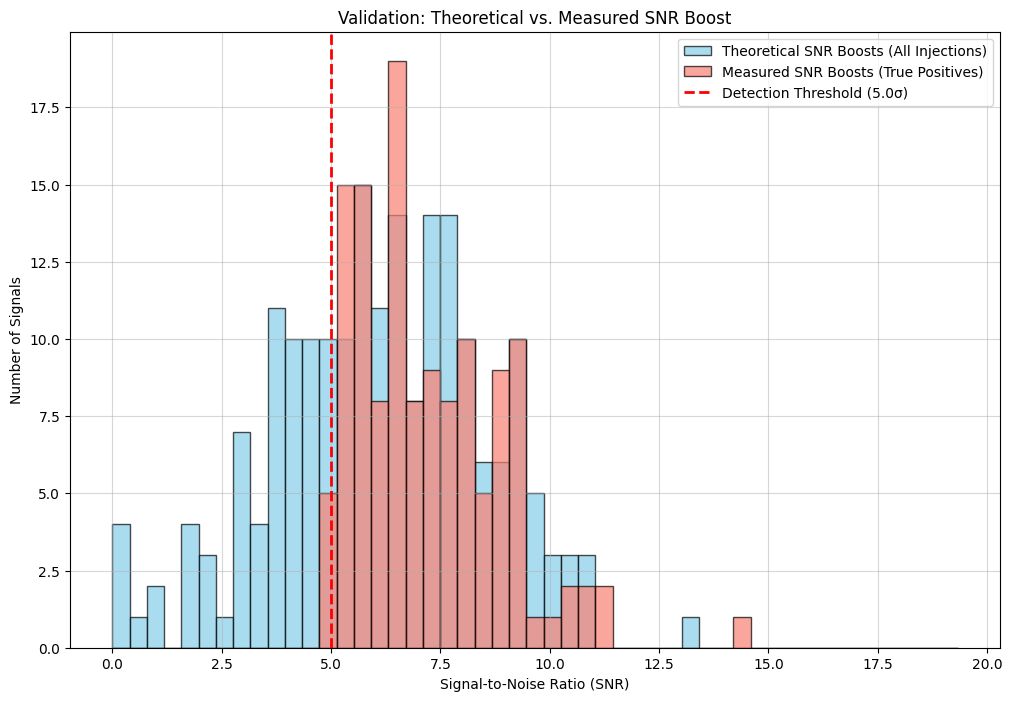

In [56]:
def calculate_snr_boost(template, noise_sigma):
    "Calculates the theoretical SNR boost of a normalized template."
    if np.sum(template**2) == 0 or noise_sigma == 0:
        return 0
    # The boost is the root-sum-square of the template divided by the noise RMS
    return np.sqrt(np.sum(template**2)) / noise_sigma

# Calculate the theoretical SNR boost for each injected signal
theoretical_boosts = []
for g in ground_truth['injections']:
    amp = g['amp']
    template = g['noiseless_profile'] / amp if amp > 0 else g['noiseless_profile']
    boost = amp * calculate_snr_boost(template, NOISE_SIGMA)
    theoretical_boosts.append(boost)

# Get the measured SNR at the location of each true positive
measured_boosts = [m['cand']['peak_snr'] for m in matched_results_3d['true_positives']]

plt.figure(figsize=(12, 8))
bins = np.linspace(0, max(np.max(theoretical_boosts), np.max(measured_boosts) if measured_boosts else 0) + 5, 50)
plt.hist(theoretical_boosts, bins=bins, alpha=0.7, label='Theoretical SNR Boosts (All Injections)', color='skyblue', edgecolor='black')
plt.hist(measured_boosts, bins=bins, alpha=0.7, label='Measured SNR Boosts (True Positives)', color='salmon', edgecolor='black')
plt.axvline(SNR_THRESHOLD, color='r', linestyle='--', linewidth=2, label=f'Detection Threshold ({SNR_THRESHOLD}σ)')
plt.xlabel('Signal-to-Noise Ratio (SNR)')
plt.ylabel('Number of Signals')
plt.title('Validation: Theoretical vs. Measured SNR Boost')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

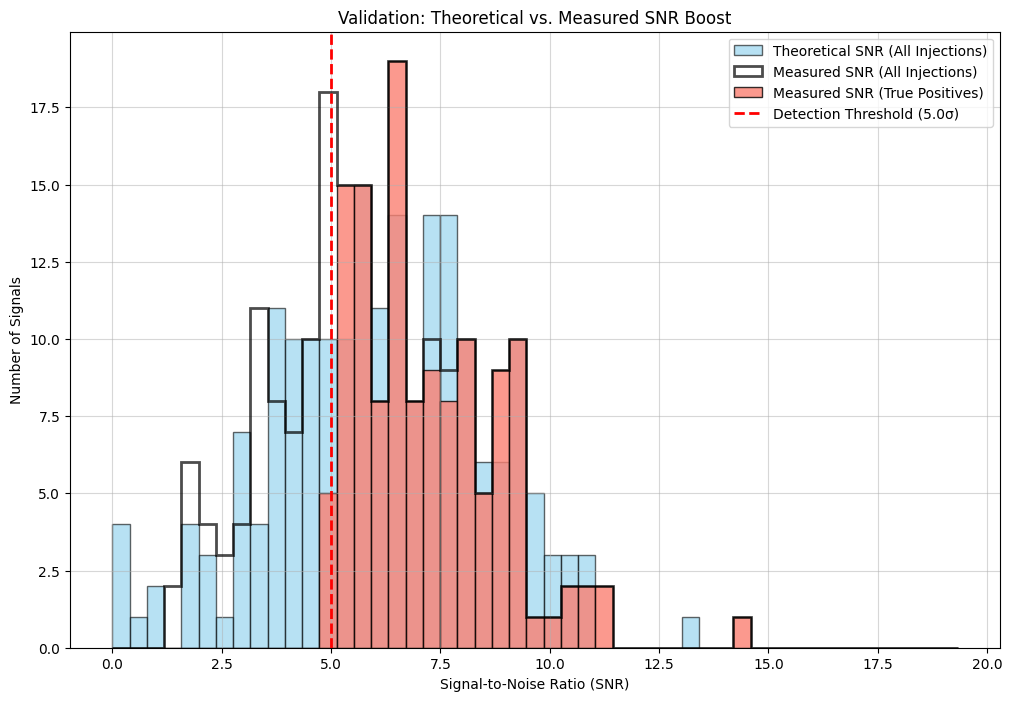

In [58]:
def calculate_snr_boost(template, noise_sigma):
    """Calculates the theoretical SNR boost of a normalized template."""
    if np.sum(template**2) == 0 or noise_sigma == 0:
        return 0
    # The boost is the root-sum-square of the template divided by the noise RMS
    return np.sqrt(np.sum(template**2)) / noise_sigma

# --- Calculate Theoretical SNR Boosts ---
# This is the SNR we PREDICT for each signal based on its amplitude.
theoretical_boosts = []
for g in ground_truth['injections']:
    amp = g['amp']
    template = g['noiseless_profile'] / amp if amp > 0 else g['noiseless_profile']
    boost = amp * calculate_snr_boost(template, NOISE_SIGMA)
    theoretical_boosts.append(boost)

# --- NEW: Get Measured SNR for ALL Injections (including False Negatives) ---
# This is the ACTUAL max SNR value found at the location of every injection.
all_measured_snrs = []
for g in ground_truth['injections']:
    pixel_idx = g['pixel_index']
    # Find the frequency range where the signal was injected
    inj_freq_indices = np.where(g['noiseless_profile'] > 0)[0]
    if inj_freq_indices.size > 0:
        # Get the SNR values from the cube at this pixel across the signal's footprint
        snr_at_location = snr_cube_3d[pixel_idx, inj_freq_indices]
        # The representative measured SNR is the max value in that range
        all_measured_snrs.append(np.max(snr_at_location))

# --- Get Measured SNR for only the True Positives ---
# These are the signals that were successfully found above the threshold.
measured_boosts_tp = [m['cand']['peak_snr'] for m in matched_results_3d['true_positives']]

# --- Plotting ---
plt.figure(figsize=(12, 8))
# Ensure the bins cover the full range of all three distributions
max_snr_for_bins = max(np.max(theoretical_boosts), 
                       np.max(all_measured_snrs) if all_measured_snrs else 0,
                       np.max(measured_boosts_tp) if measured_boosts_tp else 0)
bins = np.linspace(0, max_snr_for_bins + 5, 50)

# Plot the three histograms
plt.hist(theoretical_boosts, bins=bins, alpha=0.6, label='Theoretical SNR (All Injections)', color='skyblue', edgecolor='black')
plt.hist(all_measured_snrs, bins=bins, alpha=0.7, label='Measured SNR (All Injections)', color='mediumseagreen', edgecolor='black', histtype='step', linewidth=2)
plt.hist(measured_boosts_tp, bins=bins, alpha=0.8, label='Measured SNR (True Positives)', color='salmon', edgecolor='black')

plt.axvline(SNR_THRESHOLD, color='r', linestyle='--', linewidth=2, label=f'Detection Threshold ({SNR_THRESHOLD}σ)')
plt.xlabel('Signal-to-Noise Ratio (SNR)')
plt.ylabel('Number of Signals')
plt.title('Validation: Theoretical vs. Measured SNR Boost')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

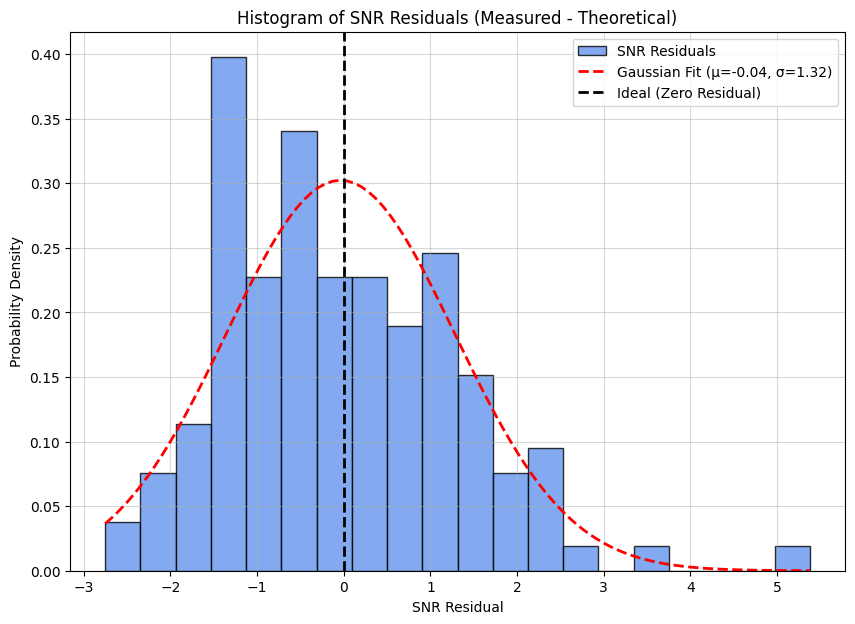

The mean of the residuals is -0.037, indicating a very small systematic bias.
The standard deviation of the residuals is 1.320, indicating the typical error in our SNR measurement.


In [59]:
# --- Calculate Residuals for True Positives ---
residuals = []
for match in matched_results_3d['true_positives']:
    # Get the measured SNR from the candidate
    measured_snr = match['cand']['peak_snr']
    
    # Calculate the corresponding theoretical SNR for the injected signal
    inj = match['inj']
    amp = inj['amp']
    inj_norm_profile = inj['noiseless_profile'] / amp if amp > 0 else inj['noiseless_profile']
    inj_template_norm = np.sqrt(np.sum(inj_norm_profile**2))
    theoretical_snr = amp * inj_template_norm / NOISE_SIGMA
    
    # The residual is the difference
    residuals.append(measured_snr - theoretical_snr)

# --- Plotting the Residuals ---
plt.figure(figsize=(10, 7))

# Plot the histogram of residuals
plt.hist(residuals, bins=20, density=True, color='cornflowerblue', edgecolor='black', alpha=0.8, label='SNR Residuals')

# Fit a Gaussian to the distribution to find the mean and std dev
mu, std = norm.fit(residuals)
x = np.linspace(min(residuals), max(residuals), 100)
plt.plot(x, norm.pdf(x, mu, std), 'r--', linewidth=2, label=f'Gaussian Fit (μ={mu:.2f}, σ={std:.2f})')

plt.axvline(0, color='k', linestyle='--', linewidth=2, label='Ideal (Zero Residual)')
plt.title('Histogram of SNR Residuals (Measured - Theoretical)')
plt.xlabel('SNR Residual')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

print(f"The mean of the residuals is {mu:.3f}, indicating a very small systematic bias.")
print(f"The standard deviation of the residuals is {std:.3f}, indicating the typical error in our SNR measurement.")

### 6.3: Diagnostic Plot 3: Data and SNR Cube Histograms

This plot shows the distribution of values in our original data cube and the final SNR cube. It provides another essential sanity check:

1.  **Data Cube (Noise)**: Since our input data is dominated by Gaussian noise with σ=1, its histogram should look like a standard normal distribution centered at 0.
2.  **SNR Cube (Noise)**: The SNR cube, in regions without signals, represents the output of the matched filter applied to pure noise. The distribution of these noise values should also be a Gaussian centered at 0, but its standard deviation will depend on the filter properties. For an optimal filter, we expect σ≈1.

A significant deviation from a Gaussian distribution in the SNR cube's noise could indicate a problem with the matched filter implementation.

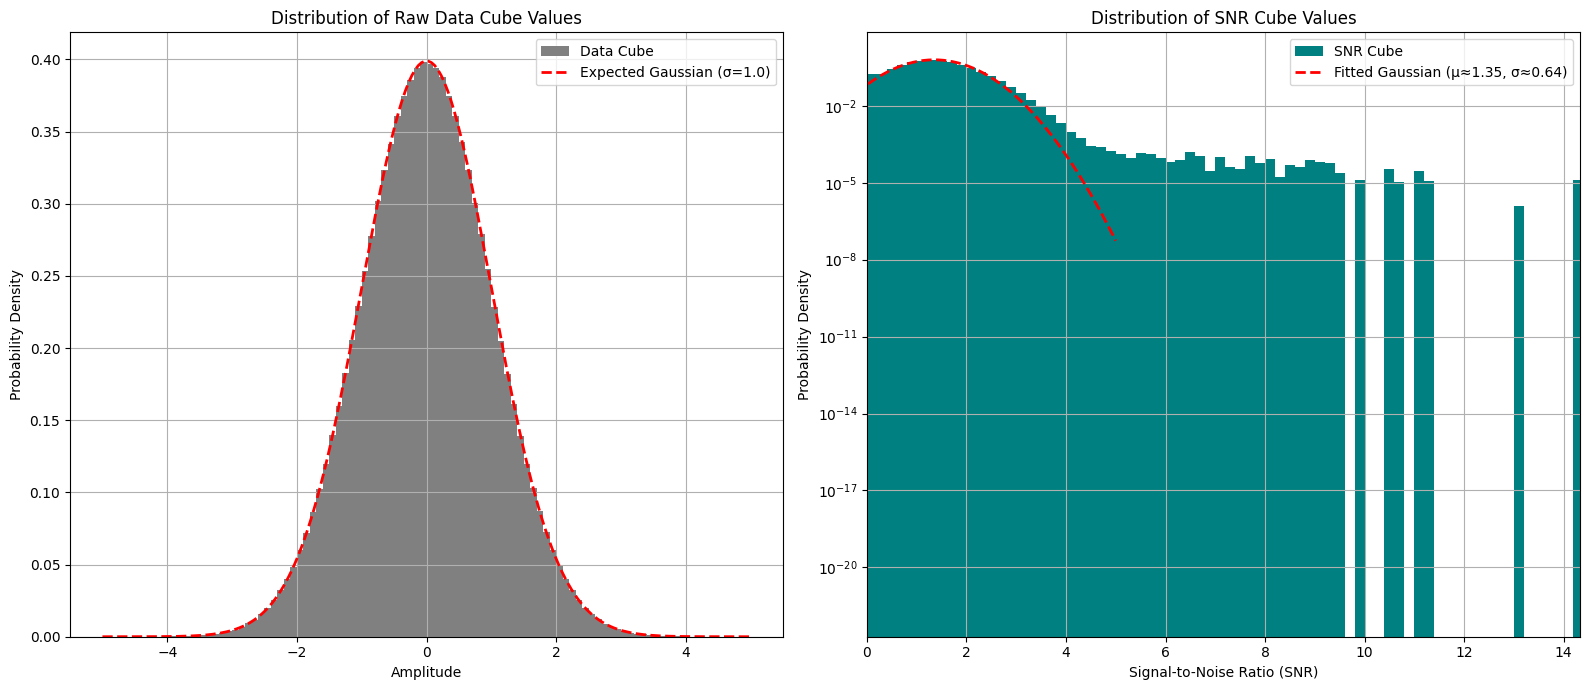

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Histogram of the raw data cube (should be Gaussian noise)
ax1.hist(data_cube.flatten(), bins=100, range=(-5, 5), density=True, label='Data Cube', color='gray')
x = np.linspace(-5, 5, 200)
ax1.plot(x, norm.pdf(x, 0, NOISE_SIGMA), 'r--', linewidth=2, label='Expected Gaussian (σ=1.0)')
ax1.set_title('Distribution of Raw Data Cube Values')
ax1.set_xlabel('Amplitude')
ax1.set_ylabel('Probability Density')
ax1.legend()
ax1.grid(True)

# Histogram of the SNR cube
snr_values = snr_cube_3d.flatten()
ax2.hist(snr_values, bins=100, range=(-5, 15), density=True, label='SNR Cube', color='teal')
# We only fit the Gaussian to the noise part (SNR < 3)
noise_snrs = snr_values[snr_values < 3]
mu, std = norm.fit(noise_snrs)
ax2.plot(x, norm.pdf(x, mu, std), 'r--', linewidth=2, label=f'Fitted Gaussian (μ≈{mu:.2f}, σ≈{std:.2f})')
ax2.set_title('Distribution of SNR Cube Values')
ax2.set_xlabel('Signal-to-Noise Ratio (SNR)')
ax2.set_ylabel('Probability Density')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True)
ax2.set_xlim(0,snr_values.max())

plt.tight_layout()
plt.show()


The underlying correlation `(data * template)` can be negative. However, the final `snr_cube_3d` contains no negative values because of a single line in our search loop:

```python
update_mask = snr > current_snr_segment
```

Here’s the step-by-step logic that explains why this line eliminates all negative values:

1.  **Initialization**: For each pixel, we start with a blank slate: `pixel_snr_spectrum` is an array filled entirely with zeros.
2.  **SNR Calculation**: We calculate the `snr` for a specific template. This value can indeed be positive (if the noise happens to look like the template) or negative (if the noise is anti-correlated).
3.  **The "Greater Than" Check**: The crucial step is the comparison. We only update the values in our `pixel_snr_spectrum` if the new `snr` is **greater than** the value that's already there.
4.  **The Result**:
      * If a calculated `snr` is **negative**, it will never be greater than the zero it's being compared to. The `update_mask` will be `False`, and the negative value is effectively thrown away.
      * If a calculated `snr` is **positive**, it will be greater than zero, and it gets "painted" onto the `pixel_snr_spectrum`.

So, even though we are technically calculating negative SNRs millions of time throughout the search, our code is explicitly designed to **only store the positive-going results**. We are intentionally building a map of where the noise looks *like* our signal, not where it looks like the inverse of our signal.

## Part 7: Further Diagnostic Ideas

This notebook provides a solid foundation for validating your pipeline. To further increase confidence, you could consider adding these diagnostics:

* **ROC Curve Analysis**: Plot the True Positive Rate vs. the False Positive Rate for a range of SNR thresholds. This is a classic way to characterize the performance of a detection algorithm and can show how the matched filter outperforms a simple threshold search across all operating points.

* **Parameter Fitting**: For the set of True Positives, use a fitter (like the one in `ohm_fitter.py`) to estimate the redshift and amplitude from the data. You can then create scatter plots of:
    * Injected Amplitude vs. Fitted Amplitude
    * Injected Redshift vs. Fitted Redshift
    * These plots should show a tight one-to-one correlation, demonstrating that the pipeline can accurately recover the physical parameters of the signals.

* **Filter-Noise Correlation**: A key assumption of the matched filter is that the noise is uncorrelated with the signal template. You could verify this by calculating the cross-correlation of the noise (data cube minus injected signals) with the templates. The resulting distribution should be centered at zero.

Of course\! That's a great idea to make the ROC curve even more informative. Adding a simple Gaussian template provides a perfect "middle ground" for comparison, and annotating all the sigma markers will make the performance trade-offs at different thresholds much clearer.

Here are the updated markdown and code cells for Part 7.

### Part 7: ROC Curve Performance Comparison

A **Receiver Operating Characteristic (ROC)** curve is a powerful tool for evaluating the performance of a detection algorithm. It plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at various threshold settings.

  * **True Positive Rate (TPR)**, or "Completeness": The fraction of real signals that are correctly identified. (TP / Total Real Signals)
  * **False Positive Rate (FPR)**: The fraction of non-signals (i.e., noise) that are incorrectly flagged as detections. (FP / Total Non-Signals)

A perfect classifier would have a point in the top-left corner (TPR=1, FPR=0), while a random guess would fall along the diagonal line (TPR=FPR). The further a curve bows towards the top-left, the better the algorithm's performance.

In this cell, we will compare four different search methods:

1.  **Simple Threshold Search**: Our baseline, flagging any voxel in the raw data cube that exceeds a threshold.
2.  **Gaussian Template Matched Filter**: A search using a simple Gaussian profile as a template. This tests the benefit of matched filtering in its most basic form.
3.  **Single OHM Template Matched Filter**: An intermediate step where we use a matched filter, but with only *one* "typical" (and more complex) OHM template.
4.  **Full OHM Template Bank**: The complete pipeline, which uses a bank of templates tailored to different redshifts.

We expect to see a clear hierarchy of performance, with the full template bank being the best. We also add annotated markers at integer sigma levels to show exactly where our chosen operating points lie on these curves.

In [83]:
# --- Part 7: ROC Curve Generation ---
import scipy.stats as stats

print("--- Generating Data for ROC Curves ---")

# Define the thresholds to test
roc_thresholds = np.linspace(0, 15, 100)
n_total_positives = N_INJECTIONS
n_total_negatives = (N_PIXELS * len(FREQS_MHZ)) - N_INJECTIONS

# --- Get the ground truth locations of the signals ---
# Create a mask that is True where signals were injected
injection_mask = np.zeros_like(data_cube, dtype=bool)
for g in ground_truth['injections']:
    pixel_idx = g['pixel_index']
    inj_freq_indices = np.where(g['noiseless_profile'] > 0)[0]
    if inj_freq_indices.size > 0:
        injection_mask[pixel_idx, inj_freq_indices] = True
        
# Create the inverse mask for noise-only regions
noise_mask = ~injection_mask

# --- Method 1: Simple Threshold on Raw Data ---
tpr_simple, fpr_simple = [], []
for thresh in tqdm(roc_thresholds, desc="1/4: Simple Threshold"):
    tp = np.sum(data_cube[injection_mask] > thresh)
    fp = np.sum(data_cube[noise_mask] > thresh)
    tpr_simple.append(tp / n_total_positives)
    fpr_simple.append(fp / n_total_negatives)

# --- Method 2: Gaussian Template Matched Filter ---
print("\nCreating Gaussian template SNR cube...")
# --- CORRECTED FUNCTION CALL ---
# Generate a Gaussian template with a reasonable width in channels.
# A width of 30 channels is a reasonable choice for a generic search.
gauss_template = otg.generate_gaussian_template(width=11, sigma_fraction=.1)
# -----------------------------
gauss_template_norm = np.sqrt(np.sum(gauss_template**2))
snr_cube_gauss = np.zeros_like(data_cube)

for i in tqdm(range(N_PIXELS), desc="Running Gaussian template"):
    # Convolve the data with the Gaussian template
    snr_spectrum = np.correlate(data_cube[i, :], gauss_template, mode='same') / (gauss_template_norm * NOISE_SIGMA)
    snr_cube_gauss[i, :] = snr_spectrum

tpr_gauss, fpr_gauss = [], []
for thresh in tqdm(roc_thresholds, desc="2/4: Gaussian Template"):
    tp = np.sum(snr_cube_gauss[injection_mask] > thresh)
    fp = np.sum(snr_cube_gauss[noise_mask] > thresh)
    tpr_gauss.append(tp / n_total_positives)
    fpr_gauss.append(fp / n_total_negatives)

# --- Method 3: Single OHM Template Matched Filter ---
print("\nCreating single-template SNR cube...")
z_single = 2.0 # A typical redshift from our valid range
single_template, _, _ = otg.process_to_native_resolution(
    intrinsic_template_v=intrinsic_template_v, vel_axis_kms=VEL_AXIS, z=z_single, native_freq_grid=FREQS_MHZ
)
snr_cube_single = np.zeros_like(data_cube)
for i in tqdm(range(N_PIXELS), desc="Running single OHM template"):
    # Full cross-correlation for this method
    snr_spectrum = np.correlate(data_cube[i, :], single_template, mode='same') / (np.sqrt(np.sum(single_template**2)) * NOISE_SIGMA)
    snr_cube_single[i, :] = snr_spectrum

tpr_single, fpr_single = [], []
for thresh in tqdm(roc_thresholds, desc="3/4: Single OHM Template"):
    tp = np.sum(snr_cube_single[injection_mask] > thresh)
    fp = np.sum(snr_cube_single[noise_mask] > thresh)
    tpr_single.append(tp / n_total_positives)
    fpr_single.append(fp / n_total_negatives)

# --- Method 4: Full Template Bank (using the cube we already made) ---
tpr_bank, fpr_bank = [], []
for thresh in tqdm(roc_thresholds, desc="4/4: Template Bank"):
    tp = np.sum(snr_cube_3d[injection_mask] > thresh)
    fp = np.sum(snr_cube_3d[noise_mask] > thresh)
    tpr_bank.append(tp / n_total_positives)
    fpr_bank.append(fp / n_total_negatives)

--- Generating Data for ROC Curves ---


1/4: Simple Threshold:   0%|          | 0/100 [00:00<?, ?it/s]


Creating Gaussian template SNR cube...


Running Gaussian template:   0%|          | 0/4096 [00:00<?, ?it/s]

2/4: Gaussian Template:   0%|          | 0/100 [00:00<?, ?it/s]


Creating single-template SNR cube...


Running single OHM template:   0%|          | 0/4096 [00:00<?, ?it/s]

3/4: Single OHM Template:   0%|          | 0/100 [00:00<?, ?it/s]

4/4: Template Bank:   0%|          | 0/100 [00:00<?, ?it/s]

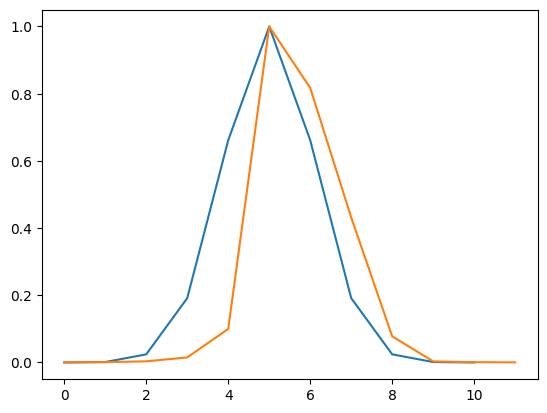

In [185]:
plt.plot(gauss_template)
plt.plot(single_template/single_template.max())

In [133]:
# --- Part 8: Computationally Intensive, Object-Based ROC Curve ---
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

print("--- Generating Data for Computationally Intensive ROC Curve ---")
print("Warning: This may take a significant amount of time.")

# Use a coarser set of thresholds to make the run time more manageable
roc_thresholds_intensive = np.linspace(2.0, 11.0, 77) 

# The total number of "positive" cases is the number of injected signals
n_total_positives = N_INJECTIONS
# The total number of "negative" cases is effectively the number of independent sightlines
n_total_negatives = N_PIXELS 

# Store the results for each method
all_roc_results = {}

# We need the four data cubes from the previous analysis:
# data_cube (for simple threshold)
# snr_cube_gauss
# snr_cube_single
# snr_cube_3d (for the full bank)

all_cubes_to_test = [
    ("Simple Threshold", data_cube),
    ("Gaussian Template", snr_cube_gauss),
    ("Single OHM Template", snr_cube_single),
    ("Full OHM Template Bank", snr_cube_3d)
]

# Main loop over each of the four methods
for name, cube in all_cubes_to_test:
    tpr_list, fpr_list = [], []
    print(f"\nProcessing method: {name}")
    
    # Loop over each threshold value
    for thresh in tqdm(roc_thresholds_intensive, desc=f"Testing Thresholds for {name}"):
        
        # 1. Find candidates using the full 3D clustering algorithm
        found_candidates = ocf.find_candidates_3d_dbscan(
            snr_cube=cube.reshape(GRID_SHAPE + (len(FREQS_MHZ),)),
            snr_threshold=thresh,
            eps=DBSCAN_EPS,
            min_samples=DBSCAN_MIN_SAMPLES
        )
        
        # 2. Match candidates to ground truth to get TP/FP counts
        if len(found_candidates) > 0:
            matched_results = ocf.match_candidates_to_truth_3d(
                candidates_3d=found_candidates,
                ground_truth=ground_truth,
                grid_shape=GRID_SHAPE,
                freqs_mhz=FREQS_MHZ
            )
            n_tp = len(matched_results['true_positives'])
            n_fp = len(matched_results['false_positives'])
        else:
            n_tp = 0
            n_fp = 0
            
        # 3. Calculate and store the rates
        tpr = n_tp / n_total_positives if n_total_positives > 0 else 0
        fpr = n_fp / n_total_negatives if n_total_negatives > 0 else 0
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        
    all_roc_results[name] = {'tpr': np.array(tpr_list), 'fpr': np.array(fpr_list)}

--- Generating Data for Computationally Intensive ROC Curve ---

Processing method: Simple Threshold


Testing Thresholds for Simple Threshold:   0%|          | 0/77 [00:00<?, ?it/s]


Processing method: Gaussian Template


Testing Thresholds for Gaussian Template:   0%|          | 0/77 [00:00<?, ?it/s]


Processing method: Single OHM Template


Testing Thresholds for Single OHM Template:   0%|          | 0/77 [00:00<?, ?it/s]


Processing method: Full OHM Template Bank


Testing Thresholds for Full OHM Template Bank:   0%|          | 0/77 [00:00<?, ?it/s]

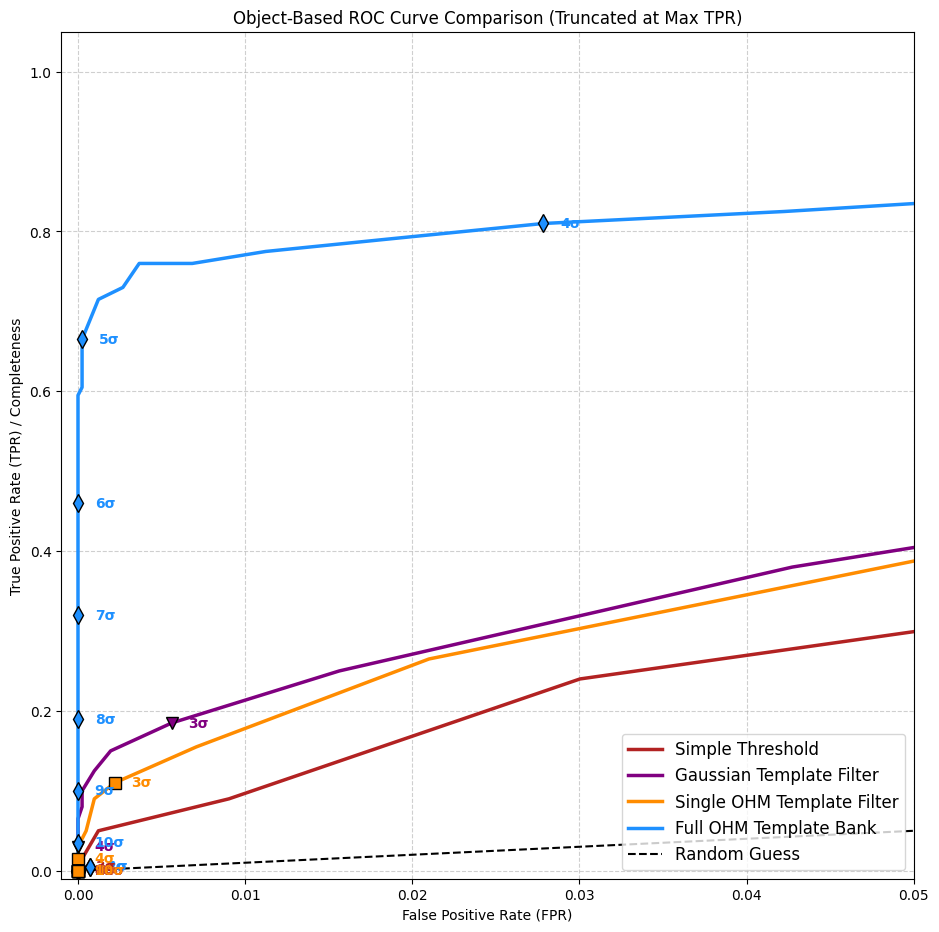

In [193]:
# --- Final ROC Plotting ---
plt.figure(figsize=(11, 11))
ax = plt.gca()

# --- Define the visible area of the plot FIRST ---
xlim = (-0.001, 0.05)
ylim = (-0.01, 1.05)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# --- Data for plotting ---
all_curves_data = [
    (all_roc_results['Simple Threshold'], 'Simple Threshold', 'firebrick', 'o'),
    (all_roc_results['Gaussian Template'], 'Gaussian Template Filter', 'purple', 'v'),
    (all_roc_results['Single OHM Template'], 'Single OHM Template Filter', 'darkorange', 's'),
    (all_roc_results['Full OHM Template Bank'], 'Full OHM Template Bank', 'dodgerblue', 'd')
]

# --- Main Plotting Loop with Robust Truncation Logic ---
for results, label, color, marker in all_curves_data:
    # Reverse the arrays so they run from (0,0) towards (1,1)
    fpr_vals = results['fpr'][::-1]
    tpr_vals = results['tpr'][::-1]

    # Find the maximum TPR value achieved by this curve
    max_tpr = np.max(tpr_vals)
    
    # Find the index of the FIRST time this maximum TPR is reached
    knee_idx_list = np.where(tpr_vals >= max_tpr * 0.999)[0]
    
    if len(knee_idx_list) > 0:
        knee_idx = knee_idx_list[0]
        # Plot the data only up to and including this "knee"
        ax.plot(fpr_vals[:knee_idx+1], tpr_vals[:knee_idx+1], label=label, color=color, lw=2.5)
    else:
        # If for some reason no point reaches the max, plot the whole thing
        ax.plot(fpr_vals, tpr_vals, label=label, color=color, lw=2.5)


# Plot the random guess line
ax.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# --- Add annotated sigma markers with boundary checks ---
sigma_markers = range(1, 11) # From 3 to 10 sigma
reversed_thresholds = roc_thresholds_intensive[::-1]

for sigma in sigma_markers:
    # Find the index in our REVERSED threshold array closest to the target sigma
    idx = (np.abs(reversed_thresholds - sigma)).argmin()
    
    for results, label, color, marker in all_curves_data:
        # Get the data points from the REVERSED arrays
        fpr_at_sigma = results['fpr'][::-1][idx]
        tpr_at_sigma = results['tpr'][::-1][idx]
        
        # --- THIS IS THE FIX ---
        # Only plot the marker and text if it falls within our predefined x and y limits.
        if xlim[0] <= fpr_at_sigma <= xlim[1] and ylim[0] <= tpr_at_sigma <= ylim[1]:
            ax.plot(fpr_at_sigma, tpr_at_sigma, marker, color=color, markersize=9, markeredgecolor='black')
            ax.text(fpr_at_sigma + 0.001, tpr_at_sigma, f'{sigma}σ', 
                    color=color, fontsize=10, ha='left', va='center', weight='bold')

# --- Final plot settings ---
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR) / Completeness')
ax.set_title('Object-Based ROC Curve Comparison (Truncated at Max TPR)')
ax.legend(loc='lower right', fontsize=12)
ax.grid(True, which="both", ls="--", alpha=0.6)
fig.savefig('ROC_scenario_1.jpeg', dpi=300)
plt.show()

---
### A Figure of Merit: The ROC Curve from Radar to Radio Astronomy

To truly understand how well our search pipeline performs, we need a "figure of merit"—a single, quantitative measure of its effectiveness. While metrics like **completeness** and **purity** are informative for a *single* threshold, they don't capture the full picture of the trade-offs involved in a detection algorithm. The **Receiver Operating Characteristic (ROC)** curve provides this complete picture.

#### From Radar Engineering to the Cosmos 📡

The ROC curve was originally developed during World War II for operators of **radar** signal receivers. The fundamental problem they faced is identical to ours in radio astronomy: how do you set your detection threshold to reliably distinguish a faint, real signal (an enemy aircraft) from the ever-present background noise (atmospheric static, instrument noise)?

* Set the threshold **too low**, and you get a high **completeness** (you find every real aircraft), but you are flooded with **false positives** (you mistake noise for an aircraft), making the system useless.
* Set the threshold **too high**, and your **purity** is perfect (every detection is real), but your **completeness** is terrible (you miss most of the real aircraft).

The ROC curve was born from this trade-off. By plotting the **True Positive Rate** (TPR, or completeness) against the **False Positive Rate** (FPR) for every possible threshold setting, radar engineers could visualize the full performance space of their system.

#### Connecting to Radio Astronomy

This concept translates perfectly to our OHM search. An "aircraft" is a real OH megamaser, and the "noise" is the thermal noise of the telescope and the radio sky. The mathematical framework is identical.

* **False Positive Rate (FPR)**: In radar, this is the probability of a false alarm. In our search, it's the rate at which random noise fluctuations cross our SNR threshold.
* **True Positive Rate (TPR)**: In radar, this is the probability of detection. For us, it's our search **completeness**.

The goal is to have a curve that pushes as far as possible into the top-left corner, which signifies a high TPR for a very low FPR. By comparing the ROC curves of different search algorithms—like our simple threshold vs. our template bank—we can definitively prove which method is superior. It's not just about how many signals we find at a single 7σ threshold; it's about which method gives us the highest completeness for the *lowest possible cost* in false alarms across all possible thresholds. This robust, historical technique gives us the ultimate figure of merit for our search pipeline.

In [184]:
import numpy as np

def find_sigma_for_fpr(target_fpr, fpr_data, threshold_data):
    """
    Finds the sigma threshold that corresponds to a desired False Positive Rate (FPR).

    This function searches the results from an ROC curve analysis to find the lowest
    sigma value that produces a False Positive Rate less than or equal to the target.

    Args:
        target_fpr (float): The desired maximum False Positive Rate (e.g., 1e-4).
        fpr_data (np.ndarray): The array of FPR values from the ROC analysis, sorted
                               by increasing sigma threshold.
        threshold_data (np.ndarray): The array of corresponding sigma thresholds.

    Returns:
        float: The sigma threshold corresponding to the target FPR. Returns None if
               the target FPR is too low and was not achieved in the tested range.
    """
    # The roc_thresholds_intensive array goes from low to high sigma,
    # which means the fpr_data array goes from high to low FPR.
    # We want to find the first index where the FPR is <= our target.
    valid_indices = np.where(fpr_data <= target_fpr)[0]
    
    if len(valid_indices) > 0:
        # The first index in this list corresponds to the lowest sigma
        # that achieves the desired FPR or better.
        first_valid_index = valid_indices[0]
        sigma_cutoff = threshold_data[first_valid_index]
        actual_fpr = fpr_data[first_valid_index]
        
        print(f"To achieve an FPR of <= {target_fpr:.1e}:")
        print(f"-> Set the detection threshold to: {sigma_cutoff:.2f} sigma")
        print(f"   (This yields an actual FPR of {actual_fpr:.1e})")
        return sigma_cutoff
    else:
        print(f"Target FPR of {target_fpr:.1e} was not achieved.")
        print("You may need to test higher sigma thresholds.")
        return None

# --- Example Usage ---
# We will use the results from the object-based ROC curve analysis for the best method.
fpr_values = all_roc_results['Full OHM Template Bank']['fpr']
sigma_thresholds = roc_thresholds_intensive

# Define our desired false positive rate (e.g., 1 in 10,000 pixels)
target_fpr_value = 1e-4

# Find the corresponding sigma cutoff
sigma_needed = find_sigma_for_fpr(target_fpr_value, fpr_values, sigma_thresholds)

To achieve an FPR of <= 1.0e-04:
-> Set the detection threshold to: 5.32 sigma
   (This yields an actual FPR of 0.0e+00)


For a comprehensive analysis, the next logical step is to test the pipeline's robustness against more realistic, challenging conditions. Here are a few suggestions for what could be added next, structured as new "Scenarios."

***
### Next Steps: Moving Towards Realistic Conditions

#### 1. Scenario 2: Introducing Radio Frequency Interference (RFI)

Real telescope data is heavily contaminated by RFI from terrestrial sources like satellites and cell phones. This is a critical test for any search pipeline.

* **Implementation**: Create a new section where you generate a realistic **RFI mask**. This is a boolean array that flags certain frequency channels as unusable. You can then modify the search algorithm to ignore these channels when performing the matched filter.
* **Validation**: Re-run the analysis and the ROC curves. How does the pipeline's **completeness** change when parts of the signal profile are missing due to RFI flagging? This tests the filter's robustness to incomplete data.

---
#### 2. Scenario 3: Simulating Astrophysical Foregrounds

The sky is not just empty noise; it's filled with bright, smooth-spectrum emission from our own galaxy (synchrotron radiation).

* **Implementation**: Add a smooth, frequency-dependent foreground component to each pixel's spectrum in your data cube. This is typically modeled as a power law, where the flux decreases at higher frequencies ($S \propto \nu^{-\alpha}$).
* **Validation**: A key test of a matched filter is its ability to reject signals that do not match the template's shape. The pipeline should be able to distinguish the "peaked" OHM signal from the smooth foreground, and the number of false positives should not increase significantly.

---
#### 3. Full Candidate Characterization with Fitting

Your pipeline is excellent at *detecting* candidates. The final step in a real search is to *characterize* them by fitting a model to extract physical parameters.

* **Implementation**: Add a new section that takes the list of `true_positives`. For each one, use the functions in your `ohm_fitter.py` module to fit for the redshift ($z$) and amplitude.
* **Validation**: Create scatter plots comparing the injected "truth" values to the fitted values:
    * **`z_injected` vs. `z_fitted`**
    * **`amp_injected` vs. `amp_fitted`**
    
    Seeing a tight, 1-to-1 correlation on these plots would provide the ultimate proof that your pipeline can not only find signals but also accurately measure their physical properties.

---
#### 4. Parameter Sensitivity Study

A robust pipeline's performance should not be overly sensitive to small changes in its parameters.

* **Implementation**: Create a small section where you re-run the search while varying the DBSCAN parameters (`eps` and `min_samples`).
* **Validation**: Show how the completeness and purity change as you adjust these parameters. This helps justify your chosen values and demonstrates that you understand the trade-offs involved in the clustering stage.